### Gated Recurrent Unit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

START = '1960-01-01'
TICKER = '^GSPC' # S&P500 Index

data = yf.download(
    TICKER,
    start = START,
    progress = False,
    interval = '1wk'
)

In [2]:
returns = data['Close'].pct_change(1).dropna()

In [3]:
import torch
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [4]:
X = pd.concat(
    [returns.shift(1), returns.shift(2)], axis = 1
).dropna()
y = returns.iloc[2:].copy('deep')

X.columns = ['t-1','t-2']
y.name = 'returns'

In [5]:
# train test data split
X_train, X_test, y_train, y_test = X.loc[:'2019'], X.loc['2020':], y.loc[:'2019'], y.loc['2020':]

이제 관측된 시계열 $\left\{ y_s\right\}_{s \leq 1}$을 평활화하는 대신 hidden vector $\hat{h}_t$를 $\hat{\alpha}_t \in [0, 1]^H$로 평활화해 다음의 필터링된 시계열을 얻는다고 가정하자. 

$$\tilde{h}_t = \hat{\alpha}_t \circ \hat{h}_t + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1}$$

여기서 $\circ$는 벡터 간의 Hadamard product이다. 평활화는 위의 고전적 설정의 벡터화된 형태다. 단지 여기서 $(\alpha_t)_i = 1$일 때 hidden vector의 $i$번째 구성의 요소는 수정되지 않고 과거 필터링된 hidden vector는 망각되는 것을 주의하라. 한편 $(\alpha_t)_i = 0$일 때 hidden vector의 $i$번째 구성 요소는 없어지고 대신 현재의 필터링된 hidden vector를 과거 값으로 설정한다. 그러면 위 식의 평활화는 장기 메모리를 업데이트하고 현재 hidden variable과 과거 평활화된 hidden variable간의 볼록 결합을 통한 메모리로 평활화된 hidden states 변수를 유지하는 것으로 볼 수 있다. hidden variable는 준어파인 변환에 의해 다음과 같이 주어진다.

$$\hat{h}_t = \sigma(U_h \tilde{h}_{t-1} + W_hx_t + b_h)$$

이번에는 hidden variable이 이전의 평활화된 hidden variable에 의존한다. 위 두 식을 이용해 다음의 식을 얻을 수 있다.

$$\tilde{h}_t = g(\tilde{h}_{t-1}, x_t ; \alpha) := \hat{\alpha}_t \circ \sigma(U_h \tilde{h}_{t-1} + W_h x_t + b_h) + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1}$$

$\alpha_t = 0$일 때 평활화된 hidden variable $\tilde{h}_t$는 입력 $x_t$에 의해 업데이트되지 않는다. 반대로 $\alpha_t = 1$일 때 hidden variable은 국지적으로 비선형 자기회귀 시계열과 같은 행태를 보인다. 따라서 평활화 파라미터는 입력 $x_t$에 대한 평활화된 상태의 민감도로 볼 수 있다.

문제는 어떻게 얼마의 오차 수정이 필요한지 동적으로 결정하는가가 된다. $\text{GRU}$는 이 문제를 가중치와 편향 $(W_\alpha, U_\alpha, b_\alpha)$에 의해 파라미터화된 기본 $\text{RNN}$을 사용해 입력 변수로부터 $\hat{\alpha} = F_{(W_\alpha, U_\alpha, b_\alpha)}(X)$를 학습함으로써 해결한다. 평활화된 hidden states $\tilde{h}_t$의 1-step forward prediction은 가중치와 편향 $(W_\alpha, U_\alpha, b_\alpha)$을 가진 또 하나의 기본 $\text{RNN}$의 필터링된 출력이다. 모든 것을 종합하면 다음의 $\alpha_t$ 모델을 얻는다 (단순 $\text{GRU}$ 네트워크이다)

$$\begin{align*} 
\tilde{h}_t &= \hat{\alpha}_t \circ \hat{h}_t + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1} \\
\hat{\alpha}_t &= \sigma^{(1)}(U_{\alpha}\tilde{h}_{t-1} + W_{\alpha}x_t + b_{\alpha}) \\
\hat{h}_{t} &= \sigma(U_h \tilde{h}_{t-1} + W_h x_t + b_h)
\end{align*}$$

여기서 $\sigma^{(1)}$은 sigmoid 또는 헤비사이드 함수이며 $\sigma$는 임의의 활성화 함수이다. 위의 $\alpha_t-\text{RNN}$에서는 메모리를 때때로 직접 망각할 방법이 없다. 이는 $U_h = 0$이 아니면 변수 업데이트 방정식이 항상 이전 평활화된 상태에 의존하기 때문이다. 그러나 적합화된 순환 가중치 $\hat{U}_h$는 일반적으로 0이 아니며, 따라서 모델은 전적인 reset button을 갖지 못한다. $\text{GRU}$는 또한 추가적인 재설정 변수를 추가함으로써 메모리를 전적으로 재설정하는 능력을 가지고 있다.

$$\begin{align*}
\tilde{h}_t &= \hat{\alpha}_t \circ \hat{h}_t + (1 - \hat{\alpha}_t) \circ \tilde{h}_{t-1} \\
\hat{\alpha}_t &= \sigma^{(1)}(U_\alpha \hat{h}_{t-1} + W_\alpha x_t + b_\alpha) \\
\hat{h}_t &= \sigma(U_h \hat{r}_t \circ \tilde{h}_{t-1} + W_h x_t + b_h) \\
\hat{r}_t &= \sigma^{(1)}(U_r \tilde{h}_{t-1} + W_r x_t + b_r)
\end{align*}$$

reset 또는 스위치 $\hat{r}_t$를 도입하는 효과는 $\hat{h}_t$의 평활화된 hidden states에 대한 의존성을 망각하는 것이다. 효과적으로 기본 $\text{RNN}$으로부터의 $\hat{h_t}$에 대한 업데이트를 $\text{FFNN}$으로 변환해 순환을 전적으로 망각할 수 있다. 따라서 $\hat{h}_t$의 업데이트에 있어 순환은 동적이다. reset과 적응적 평활화의 결합은 중복적인 것으로 보이지만 $\hat{r}_t$가 비평활화된 hidden states $\hat{h}_t$의 순환 수준을 조정하는 반면, $\hat{\alpha}_t$는 평활화된 hidden states $\tilde{h}_t$의 순환 수준에 영향을 미친다. 다르게 말하면 $\hat{\alpha}_t$ 그 자체는 평활화된 hidden states의 메모리를 제거할 수 없지만 $\hat{\alpha}_t$ 그 자체는 평활화된 hidden states의 메모리를 제거할 수 없지만 $\hat{\alpha}_t$와 결합된 $\hat{r}_t$는 가능하다. 더 정확히 $\alpha_t = 1$이고 $\hat{r}_t = 0$일 때 $\tilde{h}_t = \hat{h}_t = \sigma(W_h x_t + b_h)$이며, 이는 마지막 입력 $x_t$로 재설정되고 $\text{GRU}$는 단지 $\text{FFNN}$이 된다. EHgks $\alpha_t = 1$이고 $\hat{r}_t > 0$일 때 $\text{GRU}$는 기본 $\text{RNN}$처럼 작동한다. 따라서 $\text{GRU}$는 단지 $\text{FFNN}$이나 특정 parameter 값에서 기본 $\text{RNN}$이 될 수 있는 일반적 구조로 볼 수 있다.

이들 추가 계정은 기본 $\text{RNN}$이 학습할 수 없는 극단적으로 복잡한 장기 시계열 동학을 $\text{GRU}$가 학습할 수 있게 한다. 이러한 유연성에 대해 지불해야 할 대가는 추가적 모델 복잡도이다. 명백히 $\alpha_t \text{RNN}$과 같은 더 간단한 모델을 사용할 것인가 또는 $\text{GRU}$를 사용할 것인가를 선택해야만 한다. 마지막으로 $\text{RNN}$에서와 같이 $\text{GRU}$에서도 hidden states를 반응으로 변환하는 마지막 순전파 계층이 있다는 것을 간략히 언급한다.

$$\hat{y}_t = W_Y \tilde{h}_t + b_Y$$

In [6]:
class GatedRecurrentUnitCell(nn.Module): # nn.Module 상속
    def __init__(self, input_size, hidden_size): # initializer 생성
        super(GatedRecurrentUnitCell, self).__init__() # nn.Module로부터 initializer를 그대로 쓴다
        self.hidden_size = hidden_size
        
        self.W_alpha = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.U_alpha = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_alpha = nn.Parameter(torch.Tensor(hidden_size))
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.U_h = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.Tensor(hidden_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.W_alpha, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.U_alpha, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.W_h, a=np.sqrt(5))
        nn.init.kaiming_uniform_(self.U_h, a=np.sqrt(5))
        nn.init.zeros_(self.b_alpha)
        nn.init.zeros_(self.b_h)

    def forward(self, x, h_prev, h_smooth_prev):
        alpha_t = torch.matmul(x, self.W_alpha.t()) + torch.matmul(h_smooth_prev, self.U_alpha.t()) + self.b_alpha


        h_hat_t = torch.matmul(x, self.W_h.t()) + torch.matmul(h_smooth_prev, self.U_h.t()) + self.b_h

        h_smooth_t = alpha_t * h_hat_t + (1 - alpha_t) * h_smooth_prev
        
        return h_smooth_t, h_hat_t

class GatedRecurrentUnit(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GatedRecurrentUnit, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = nn.ModuleList(
            [GatedRecurrentUnitCell(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)]
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_prev = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        h_smooth_prev = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            for i in range(self.num_layers):
                h_smooth_prev[i], h_prev[i] = self.layers[i](x_t, h_prev[i], h_smooth_prev[i])
                x_t = h_smooth_prev[i] 
                
        output = self.fc(h_smooth_prev[-1])
        
        return output

In [7]:
input_size = 2 # input size (number of features), GRU(p)
hidden_size = 10 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1
batch_size = 1

In [8]:
# Feature Preprocessing
X_train_values = X_train.values.reshape(-1, 1, input_size)
X_test_values = X_test.values.reshape(-1, 1, input_size)

y_train_values = y_train.values.reshape(-1, 1)
y_test_values = y_test.values.reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test_values, dtype = torch.float32)

In [9]:
dataset = torch.utils.data.TensorDataset(
    X_train_tensor, 
    y_train_tensor
)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle = False
)

In [10]:
gru = GatedRecurrentUnit(
    input_size, 
    hidden_size,
    output_size, 
    num_layers
)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    gru.parameters(), 
    lr = learning_rate
)

In [11]:
for epoch in range(num_epochs):
    gru.train()
    optimizer.zero_grad()

    outputs = gru(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.011051


In [12]:
gru.eval()
with torch.no_grad():
    predicted_gru = gru(X_test_tensor).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

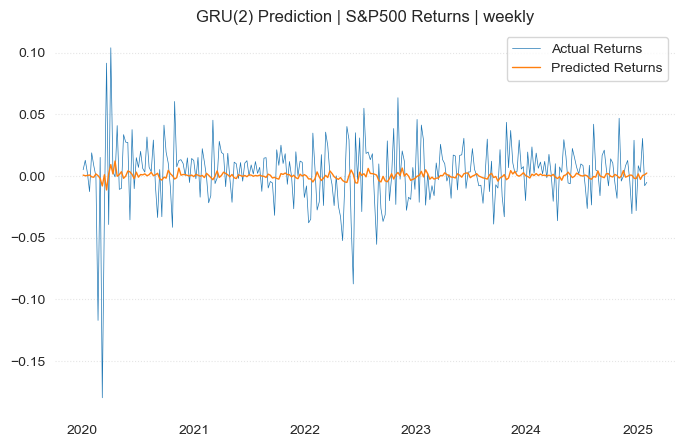

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_gru, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'GRU(2) Prediction | S&P500 Returns | weekly')
plt.show()

### Long Short Term Memory

$\text{GRU}$는 평활화된 은닉 상태를 전파하기 위한 게이트 매커니즘을 제공하며, 이는 재정의될 수 있고 $\text{GRU}$를 기본 $\text{RNN}$이나 심지어 기억이 없는 Feed Forward Neural Network로 만들 수도 있다. 메모리 단위 내에서 다양한 연결을 가진 Hidden Unit을 사용한느 좀 더 복잡한 모델이 공학 문헌에서 실증적 성공을 갖고 제안됐다. $\text{LSTM}$은 $\text{GRU}$와 유사하지만 Hidden State 외에 별도의 Cell Memory인 $C_t$를 가지고 있다. 또한 $\text{LSTM}$은 메모리 업데이트가 블록 결합일 필요는 없다. 따라서 지수 평활화보다 일반적이다. $\text{LSTM}$의 수학적 설명은 직관적인 형태로 제공되는 경우는 드물지만 모델은 예를들어 Hochreiter와 Schmidhuber에서 찾을 수 있다.

Cell Memory는 forgot gate $\hat{\alpha}_t$, input gate $\hat{z}_t$와 cell gate $\hat{c}_t$와 연관된 다음의 표현식에 의해 업데이트된다.

$$c_t = \hat{\alpha}_t \circ c_{t-1} + \hat{z}_t \circ \hat{c}_t$$

$\text{LSTM}$의 언어로 $\hat{\alpha}_t, \hat{r}_t, \hat{z}_t$는 각각 forgot gate, output gate, input gate라 불린다. $\hat{z}_t = 1 - \hat{\alpha}_t$인 특수한 경우 $\text{GRU}$에서 사용된 것과 같은 유사한 지수 평활화 표현식을 얻는다. 이것을 넘어서 input gate의 역할은 필요 없으며 시계열 분석으로 논리를 피는 것도 어려운 것 같다. 유사하게 이는 단지 공학 모델의 맥락에서 나온다. 그러나 어떻게 추가적인 변수가 $\text{LSTM}$에 복잡하고 더 정교한 표현의 시간적 동학을 제공하는지 탐구할 만 하다.

Forgot gate가 $\hat{\alpha}_t = 0$일 때 Cell memory는 Cell memory date update $\hat{c}_t$에만 의존한다. $\hat{\alpha}_t \circ c_{t-1}$항에 의해 Cell memory는 $\hat{\alpha}_{t-s} = 0$이면 lag $s$를 넘어설 때에만 망각하는 long memory이다. Hidden State로 취급되고 Cell Memory와 분리된 추가 메모리는 아마다르 곱일 뿐이다.

$$\hat{h}_t = \hat{r}_t \circ \tanh(c)_t$$

여기서 $\hat{r}_t = 0$이면 재설정된다. $\hat{r}_t = 1$이면 Cell memory는 직접 hidden state를 결정한다. 따라서 reset gate는 전적으로 Cell memory의 자기회귀 구조 효과를 지우지 않고 재설정한다. 대조적으로 $\text{GRU}$는 hidden state의 역할을 하는 하나의 메모리를 갖고 있으며, 이는 reset gate에 직접 영향을 받는다. reset, forgot, input, cell memory gate는 기본 $\text{RNN}$에 의해 업데이트 되며 모두 hidden state $h_t$에 의존한다.

$$\begin{align*}
\hat{r}_t &= \sigma(U_r h_{t-1} + W_r x_t + b_r) \\ 
\hat{\alpha}_t &= \sigma(U_\alpha h_{t-1} + W_\alpha x_t + b_\alpha) \\
\hat{z}_t &= \sigma(U_z h_{t-1} + W_z x_t + b_z) \\
\hat{c}_t &= \tanh(U_c h_{t-1} + W_c x_t + b_c)
\end{align*}$$

$\text{GRU}$와 마찬가지로 $\text{LSTM}$도 간단한 $\text{RNN}$으로 작동할 수 있다. 위 식에서 $\alpha_t = 0$으로 설정하기만 하면 된다. 그러나 $\text{LSTM}$은 $\text{FFN}$의 결합으로서도 작동할 수 있다. 단지 $\hat{r}_t$로 설정하면 $h_t = 0$이므로 게이트에 순환 구조가 존재하지 않는다. 명명법이 제안하지 않더라고 $\text{GRU}$와 $\text{LSTM}$ 모두 장기 및 단기 자기회귀 메모리를 모델링할 수 있다. $\text{GRU}$는 이러한 값을 평활화된 hidden state 변수를 통해 결합한다. $\text{LSTM}$은 셀 메머리에 저장된 장기 메모리를 분리하지만 추가로 재설정될 수 있는 복사본을 사용한다. 엄밀히 말하면 Cell memory는 단기-장기 자기회귀 메모리 구조를 가지고 있기 때문에 두 개의 메뫼를 엄격히 구분하는 것은 시계열 분석의 맥락에서 오해의 소지가 있다. 후가는 전자의 절단된 버전으로 생각할 수 있다.

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

In [16]:
input_size = 2 # input size (number of features), RNN(p)
hidden_size = 2 # number of hidden nodes
output_size = 1 # output size
num_layers = 1 # number of hidden layers
learning_rate = 0.1
num_epochs = 1
batch_size = 1

In [17]:
lstm = LSTM(
    input_size, 
    hidden_size, 
    output_size, 
    num_layers
)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    lstm.parameters(), 
    lr = learning_rate
)

In [18]:
for epoch in range(num_epochs):
    lstm.train()
    optimizer.zero_grad()

    outputs = lstm(X_train_tensor)

    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/1], Loss: 0.025427


In [19]:
lstm.eval() # 평가모드 
with torch.no_grad():
    predicted_lstm = lstm(X_test_tensor).squeeze().numpy()
    y_test_np = y_test_tensor.squeeze().numpy()

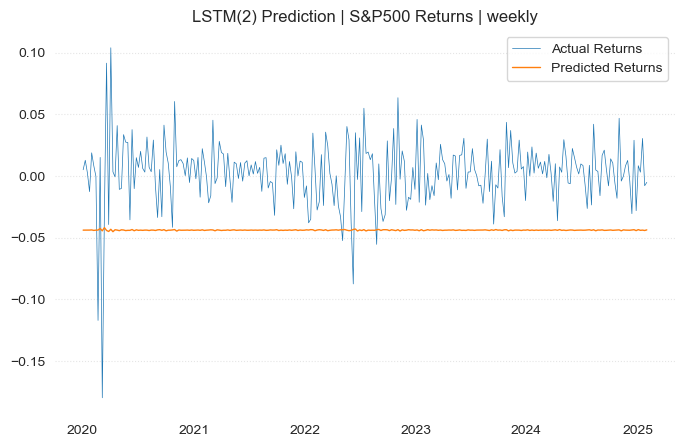

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(y_test.index, y_test_np, label = 'Actual Returns', lw = 0.5)
plt.plot(y_test.index, predicted_lstm, label = 'Predicted Returns', lw = 1)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title(r'LSTM(2) Prediction | S&P500 Returns | weekly')
plt.show()